# Setting Up

In [ ]:
#  Libraries are loaded.
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# To allow access to drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [ ]:
# Directory path.
dataset = '/content/drive/MyDrive/machine_learning/imageset'

# Used to check the folders in dataset.
file_list = os.listdir(dataset)
print(file_list)

['train', 'val']


In [ ]:
# Resizing images and batching.

SIZE_BATCH = 64
SIZE_IMG = (128,128)

# Directory paths for the test and training data.
train_dir = '/content/drive/MyDrive/machine_learning/imageset/train'
test_dir = '/content/drive/MyDrive/machine_learning/imageset/val'

# The folders are renamed for classification.

rename_label = {
    'n01440764': 'fish',
    'n02102040': 'springer_spaniel',
    'n02979186': 'cassette',
    'n03000684': 'chain_saw',
    'n03028079': 'church',
    'n03394916': 'french_horn',
    'n03417042': 'garbage truck',
    'n03425413': 'petrol_station',
    'n03445777': 'golf_ball',
    'n03888257': 'parachute'
}

def rename_folder(folder_path, rename):
  """Uses the items in the dictionary to rename the folders.
  Args: The folder path is the first condition, and the dictionary
  is the second"""
  for old_name, new_name in rename.items():
    old = os.path.join(folder_path, old_name)
    new = os.path.join(folder_path, new_name)
    if os.path.exists(old):
      os.rename(old, new)

rename_folder(train_dir, rename_label)
rename_folder(test_dir, rename_label)

print("The folders were renamed successfully!\n")

# Preprocessing the images.
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle = True,
    batch_size = SIZE_BATCH,
    image_size = SIZE_IMG,
    label_mode = 'categorical',
)

test_dataset = image_dataset_from_directory(
    test_dir,
    batch_size = SIZE_BATCH,
    image_size = SIZE_IMG,
    label_mode = 'categorical',
    shuffle = False
)

The folders were renamed successfully!

Found 9469 files belonging to 10 classes.
Found 3925 files belonging to 10 classes.


In [ ]:
# To check if classes were renamed correctly.
category_name = train_dataset.class_names
print("Categories:", category_name)

Categories: ['cassette', 'chain_saw', 'church', 'fish', 'french_horn', 'garbage truck', 'golf_ball', 'parachute', 'petrol_station', 'springer_spaniel']


# Data Statistics

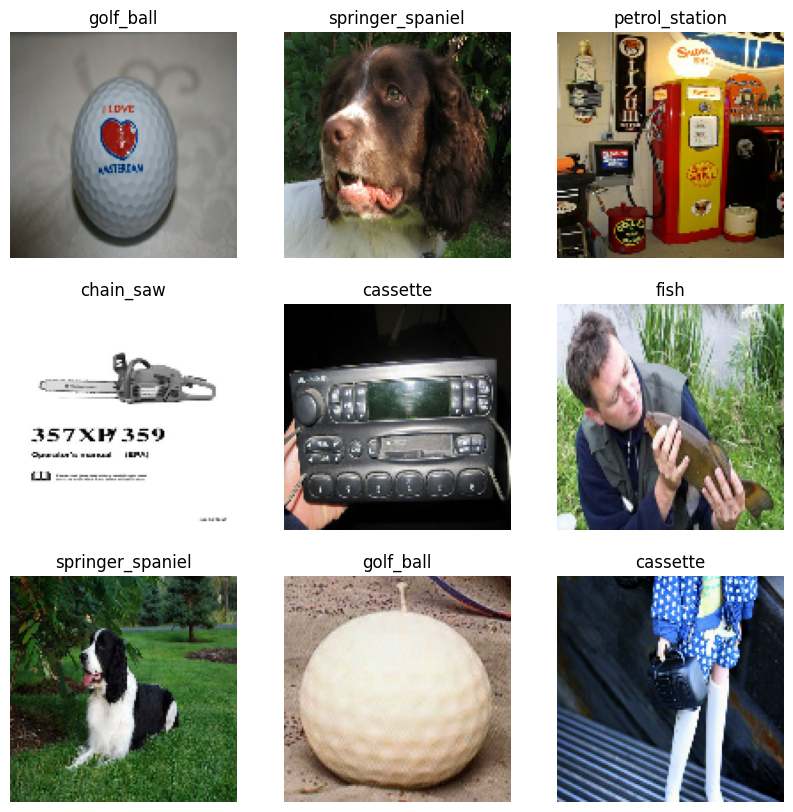

In [ ]:
# Displays the images in the training folder.
# Code copied from: Lab 6.
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    label_index = np.argmax(labels[i].numpy())
    plt.title(category_name[label_index])

    plt.axis("off")

In [ ]:
# Shows how many training and testing images are in each class
train_counts = []
test_counts = []

for name in category_name:
  train_category = os.path.join(train_dir,name)
  test_category = os.path.join(test_dir,name)

  test_num = len(os.listdir(test_category))
  train_num = len(os.listdir(train_category))

  train_counts.append(train_num)
  test_counts.append(test_num)

  print(f"{name}: {train_num} training images, {test_num} testing images.")


cassette: 993 training images, 357 testing images.
chain_saw: 858 training images, 386 testing images.
church: 941 training images, 409 testing images.
fish: 963 training images, 387 testing images.
french_horn: 956 training images, 394 testing images.
garbage truck: 961 training images, 389 testing images.
golf_ball: 951 training images, 399 testing images.
parachute: 960 training images, 390 testing images.
petrol_station: 931 training images, 419 testing images.
springer_spaniel: 955 training images, 395 testing images.


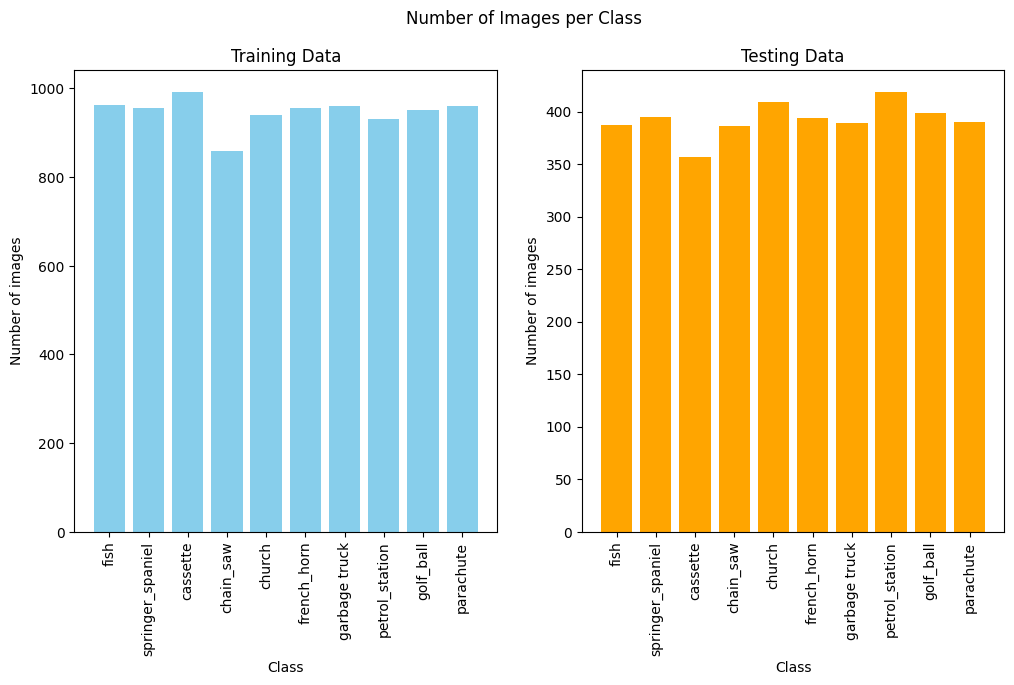

In [ ]:
# Visual reprentation of balance across the data

train_classes = os.listdir(train_dir)
test_classes = os.listdir(test_dir)

# Number of images is counted in each class
# Adapted from: [https://www.kaggle.com/code/rabieelkharoua/fruit-veg-image-classification-cnn-acc-97/notebook]
train_image_count = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls
                     in train_classes}
test_image_count = {cls: len(os.listdir(os.path.join(test_dir,cls))) for cls in
                    test_classes}

fig, axs = plt.subplots(1,2, figsize = (12,6))
fig.suptitle('Number of Images per Class')

axs[0].bar(train_classes, train_image_count.values(), color = 'skyblue')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Number of images')
axs[0].set_title('Training Data')
axs[0].set_xticks(train_classes)
axs[0].set_xticklabels(train_classes, rotation = 90)
axs[1].bar(test_classes, test_image_count.values(), color = 'orange')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Number of images')
axs[1].set_title('Testing Data')
axs[1].set_xticks(test_classes)
axs[1].set_xticklabels(test_classes, rotation = 90)
plt.show()


# Model

In [ ]:
# CNN model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input



model = models.Sequential([
    Input(shape=(128, 128, 3)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(10, activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,152,202 (4.40 MB)

 Trainable params: 1,151,402 (4.39 MB)

 Non-trainable params: 800 (3.12 KB)

In [ ]:
# To understand which layers are non trainable
# Adapted from:[https://stackoverflow.com/questions/67713547/tensorflow-how-to-get-layers-with-trainable-parameters]
for layer in model.layers:
    print(f"{layer.name}: Layer Trainable = {layer.trainable}, Parameters = {layer.count_params()}")

conv2d: Layer Trainable = True, Parameters = 448
batch_normalization: Layer Trainable = True, Parameters = 64
max_pooling2d: Layer Trainable = True, Parameters = 0
conv2d_1: Layer Trainable = True, Parameters = 4640
batch_normalization_1: Layer Trainable = True, Parameters = 128
max_pooling2d_1: Layer Trainable = True, Parameters = 0
conv2d_2: Layer Trainable = True, Parameters = 18496
batch_normalization_2: Layer Trainable = True, Parameters = 256
max_pooling2d_2: Layer Trainable = True, Parameters = 0
conv2d_3: Layer Trainable = True, Parameters = 73856
batch_normalization_3: Layer Trainable = True, Parameters = 512
max_pooling2d_3: Layer Trainable = True, Parameters = 0
flatten: Layer Trainable = True, Parameters = 0
dense: Layer Trainable = True, Parameters = 1048704
batch_normalization_4: Layer Trainable = True, Parameters = 512
dropout: Layer Trainable = True, Parameters = 0
dense_1: Layer Trainable = True, Parameters = 4128
batch_normalization_5: Layer Trainable = True, Paramete

In [ ]:

# Setting an early stopping to prevent model from going through all Epochs.
# Adapted from: [https://www.kaggle.com/code/rabieelkharoua/fruit-veg-image-classification-cnn-acc-97/notebook]

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    verbose = 1,
    mode = 'min',
    restore_best_weights = True
)

checkpoint = ModelCheckpoint(
    'a_model.keras',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)

# fit model

history = model.fit(
    train_dataset,
    epochs = 20,
    validation_data = test_dataset,
    callbacks = [early, checkpoint]
)


Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.2823 - loss: 2.2557
Epoch 1: val_loss improved from inf to 1.52218, saving model to a_model.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 36s 177ms/step - accuracy: 0.2829 - loss: 2.2537 - val_accuracy: 0.5190 - val_loss: 1.5222
Epoch 2/20
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5243 - loss: 1.4402
Epoch 2: val_loss improved from 1.52218 to 1.13819, saving model to a_model.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.5249 - loss: 1.4388 - val_accuracy: 0.6285 - val_loss: 1.1382
Epoch 3/20
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6520 - loss: 1.1133
Epoch 3: val_loss did not improve from 1.13819
148/148 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.6521 - loss: 1.1128 - val_accuracy: 0.6104 - val_loss: 1.2202
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7045 - loss: 0.9516
Epoch 4: val_loss improved from 1.13819 to 1.12417, saving model to a_model.keras
14

# Visualisation of Model

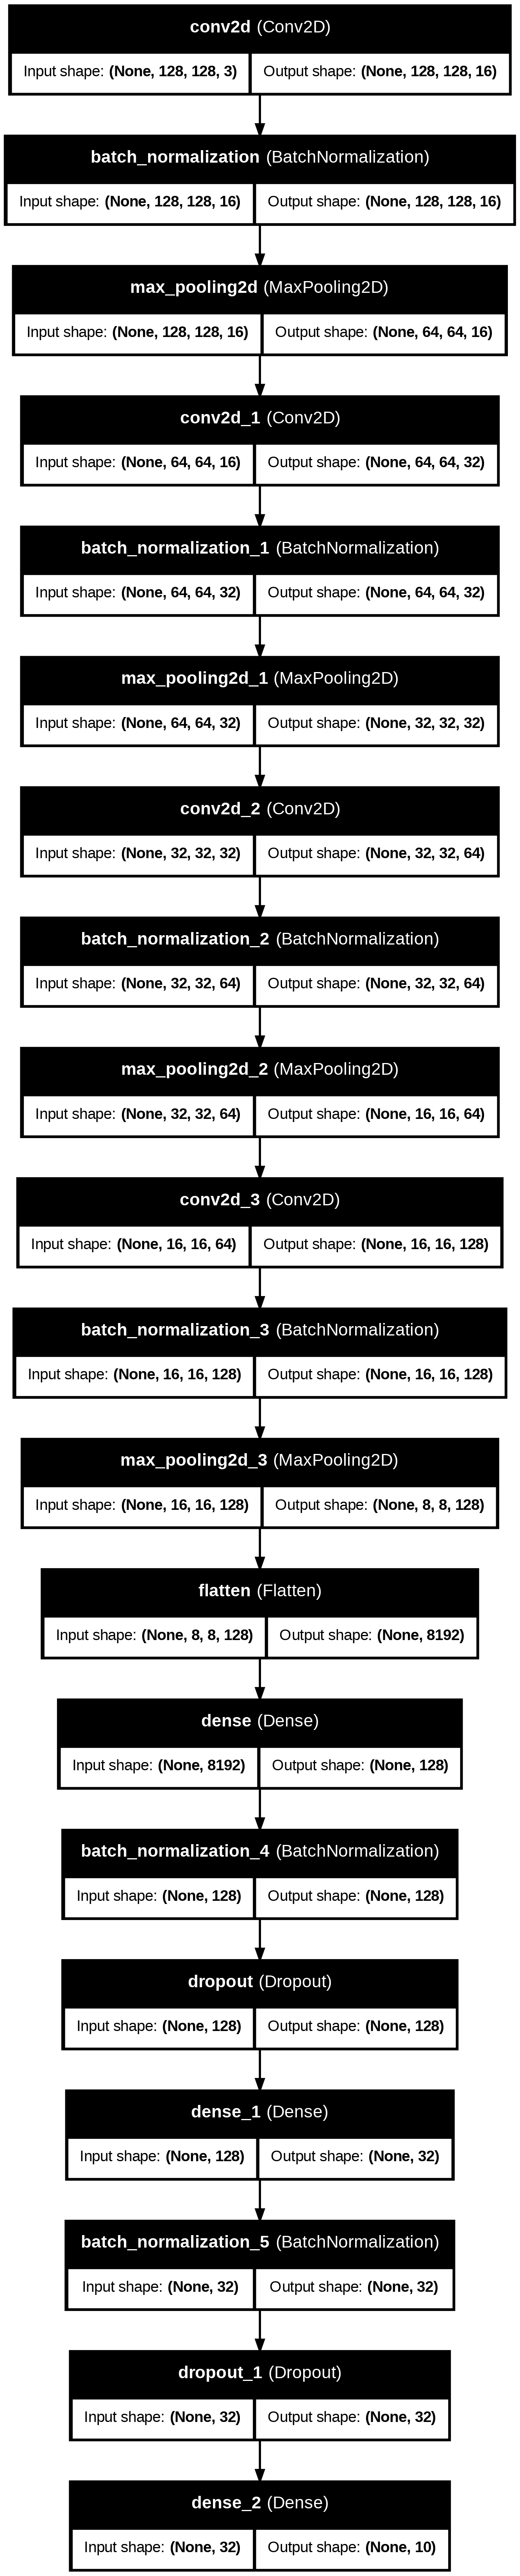

In [ ]:
# Architecture diagram
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='a_model.png', show_shapes = True, show_layer_names =
           True)

Image(filename = 'a_model.png')


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


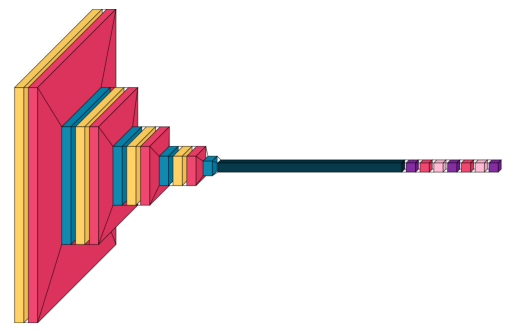

In [ ]:
# 3D representation of CNN model
!pip install visualkeras
from tensorflow.keras.models import load_model
import visualkeras
from PIL import Image

model_path = 'a_model.keras'
model = load_model(model_path)

visualisation = 'a_model.png'
visualkeras.layered_view(model).save(visualisation)

img_cnn = Image.open(visualisation)
plt.figure()
plt.imshow(img_cnn)
plt.axis('off')
plt.show()

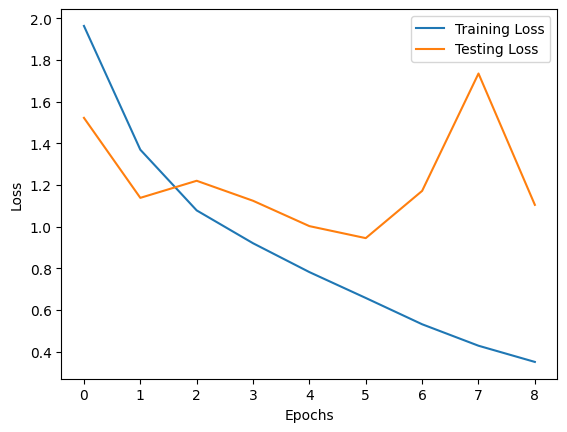

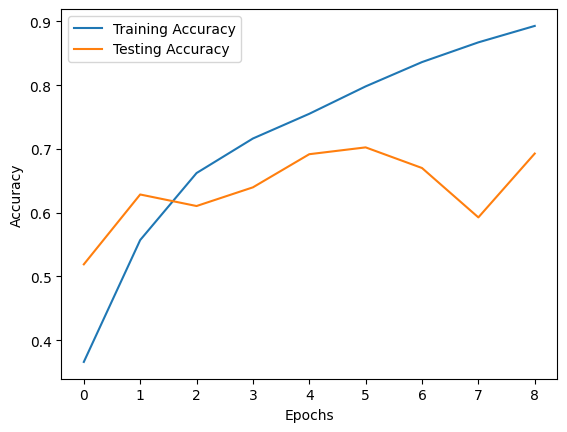

In [ ]:
# Plot of loss
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot of Accuaracy
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step


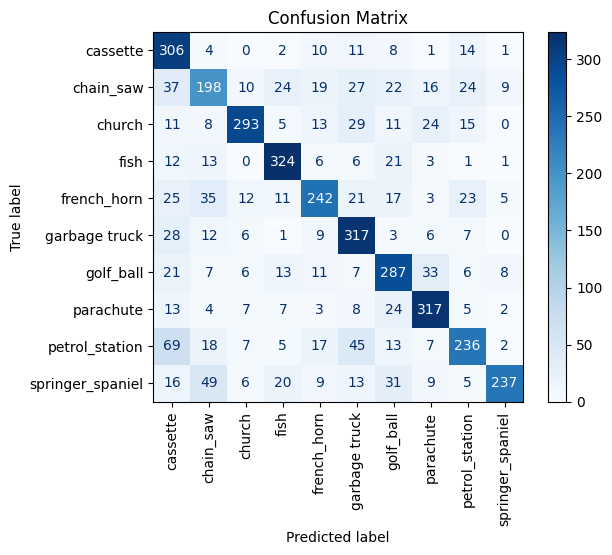

In [ ]:
# Confusion Matrix

predicted_prob = model.predict(test_dataset)
predicted_labels = np.argmax(predicted_prob, axis=1)


true_labels = []
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels, axis=1))

true_labels = np.array(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = category_name)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation = 90)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Summary of classification

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

print(classification_report(true_labels, predicted_labels, target_names = category_name))

Accuracy: 0.7024203821656051
                  precision    recall  f1-score   support

        cassette       0.57      0.86      0.68       357
       chain_saw       0.57      0.51      0.54       386
          church       0.84      0.72      0.78       409
            fish       0.79      0.84      0.81       387
     french_horn       0.71      0.61      0.66       394
   garbage truck       0.65      0.81      0.73       389
       golf_ball       0.66      0.72      0.69       399
       parachute       0.76      0.81      0.78       390
  petrol_station       0.70      0.56      0.63       419
springer_spaniel       0.89      0.60      0.72       395

        accuracy                           0.70      3925
       macro avg       0.71      0.70      0.70      3925
    weighted avg       0.72      0.70      0.70      3925



# Improved Model

In [ ]:
checkpoint_aug = ModelCheckpoint(
    'b_model.keras',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)


train_aug = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = train_aug.flow_from_directory(
    train_dir,
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True
)


test_aug = ImageDataGenerator(rescale = 1./255)

test_generator = test_aug.flow_from_directory(
    test_dir,
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_aug = model.fit(
    train_generator,
    epochs = 20,
    validation_data = test_generator,
    callbacks = [early, checkpoint_aug]
)



Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.6385 - loss: 1.1852
Epoch 1: val_loss improved from inf to 3.73507, saving model to b_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 112s 345ms/step - accuracy: 0.6385 - loss: 1.1851 - val_accuracy: 0.1017 - val_loss: 3.7351
Epoch 2/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.6744 - loss: 1.0113
Epoch 2: val_loss did not improve from 3.73507
296/296 ━━━━━━━━━━━━━━━━━━━━ 96s 323ms/step - accuracy: 0.6744 - loss: 1.0113 - val_accuracy: 0.1060 - val_loss: 4.0255
Epoch 3/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.6958 - loss: 0.9542
Epoch 3: val_loss improved from 3.73507 to 1.81427, saving model to b_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 98s 331ms/step - accuracy: 0.6958 - loss: 0.9542 - val_accuracy: 0.3572 - val_loss: 1.8143
Epoch 4/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7276 - loss: 0.8796
Epoch 4: val_loss improved from 1.81427 to 1.22511, saving model to b_model.kera

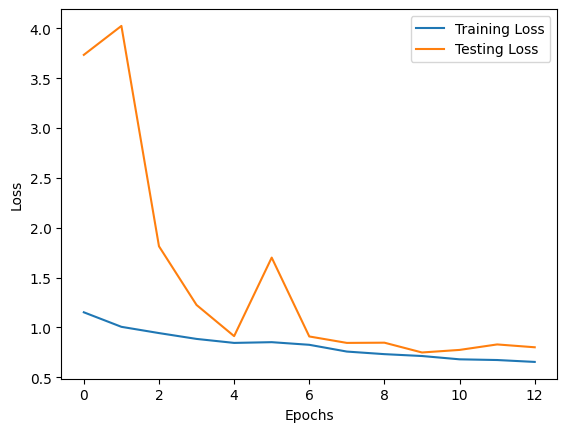

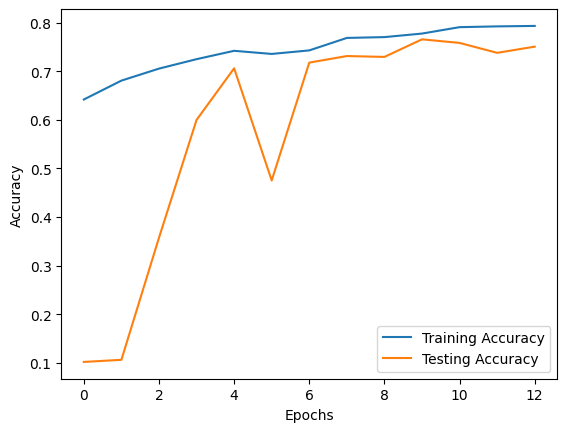

In [ ]:
# Plot of loss
plt.plot(history_aug.history['loss'], label = 'Training Loss')
plt.plot(history_aug.history['val_loss'], label = 'Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot of Accuaracy
plt.plot(history_aug.history['accuracy'], label = 'Training Accuracy')
plt.plot(history_aug.history['val_accuracy'], label = 'Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
# Prediction and true labels

num_samples = test_generator.samples

pred_prob = model.predict(test_generator, verbose=1)
pred_labels = np.argmax(pred_prob, axis=1)

labels = test_generator.classes

123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step


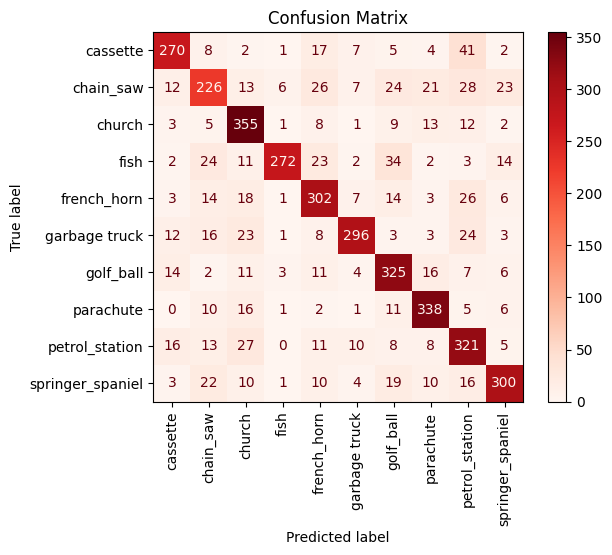

In [ ]:
#  Confusion matrix

b_cm = confusion_matrix(labels, pred_labels)

b_disp = ConfusionMatrixDisplay(confusion_matrix=b_cm, display_labels=category_name)
b_disp.plot(cmap=plt.cm.Reds)
plt.xticks(rotation=90)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#  Classification report & accuracy

accuracy = accuracy_score(labels, pred_labels)
print(f'Accuracy: {accuracy}')

print(classification_report(labels, pred_labels, target_names=category_name))

Accuracy: 0.7656050955414013
                  precision    recall  f1-score   support

        cassette       0.81      0.76      0.78       357
       chain_saw       0.66      0.59      0.62       386
          church       0.73      0.87      0.79       409
            fish       0.95      0.70      0.81       387
     french_horn       0.72      0.77      0.74       394
   garbage truck       0.87      0.76      0.81       389
       golf_ball       0.72      0.81      0.76       399
       parachute       0.81      0.87      0.84       390
  petrol_station       0.66      0.77      0.71       419
springer_spaniel       0.82      0.76      0.79       395

        accuracy                           0.77      3925
       macro avg       0.78      0.76      0.77      3925
    weighted avg       0.77      0.77      0.77      3925

